# questions
- can i put a timing thing into these function calls?
- tick and toc the function calls and plot bars over time showing the execution
- plot some speedups

In [20]:
%load_ext Cython
from concurrent import futures
import numpy as np
from collections import defaultdict
from select import select
from pprint import pprint
import functools

import time
import os
import threading

from itertools import repeat, count

def f_wrap(f, n, task_id):
    pid = os.getpid()
    tid = threading.get_ident()
    start_time = time.time()
    
    result = f(n)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    info = dict(pid=pid, tid=tid, start_time=start_time, end_time=end_time, elapsed_time=elapsed_time,
               n=n, task_id=task_id, result=result)
    
    return info
        
# todo, have it return the total time
# todo: have f perform the same computation everywhere
def meta_map(f, g, executor=None, workers=1):
    if executor is None:
        ex = None
        pmap = map
    else:
        ex = executor(workers)
        pmap = ex.map
        
    task_ids = count(0)
    fs = repeat(f)
        
    yield from pmap(f_wrap, fs, g, task_ids)

    if ex is not None:
        ex.shutdown()
        
def speedup(f, value, n, executor=None, workers=1, runs=4):
    if executor is None:
        ex = None
        pmap = map
    else:
        ex = executor(workers)
        pmap = ex.map
        
    time1 = np.inf
    for _ in range(runs):
        start_time = time.time()
        f(value)
        end_time = time.time()
        time1 = min(time1, end_time-start_time)
        
    g = repeat(value, n)
    start_time = time.time()
    for _ in pmap(f, g):
        pass
    end_time = time.time()
    elapsed_time = end_time - start_time
        
    if ex is not None:
        ex.shutdown()
        
    return time1*n/elapsed_time

def exec_loc(g):
    "pid, thread_id execution location for each task_id"
    d = defaultdict(list)
    for info in g:
        t = (info['pid'], info['tid'])
        d[t] += [info['task_id']]
    return d

def worker_id(infos):
    d = {}

    for info in g:
        k = (info['pid'], info['tid'])
        if k not in d:
            d[k] = len(d)
    
    for info in g:
        k = (info['pid'], info['tid'])
        
        del info['pid']
        del info['tid']
        
        info['wid'] = d[k]

def zero_time(infos):
    min_time = np.inf
    for info in g:
        min_time = min(info['start_time'], min_time)
        
    for info in g:
        info['start_time'] -= min_time
        info['end_time'] -= min_time

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [30]:
# compute bound?

def rand_sum(n):
    a = np.sum(np.random.randn(n))

# io bound
def select_time(n):
    select([], [], [], 1)

# compute bound
def npexp(n):
    y = np.ones(n)
    np.exp(y)

In [3]:
%%cython

from cython cimport boundscheck

def test(n):
    cdef int m = n
    cdef int i, j
    cdef float a
    a = 0.0
    
    with nogil:
        for i in range(m):
            for j in range(m):
                a += (i+j)**2-i**2-j**2
    
    return a


#doesn't get multithread speedup
cpdef float test2(int n) nogil:
    cdef int i, j
    cdef float a
    a = 0.0
    
    for i in range(n):
        for j in range(n):
            a += (i+j)**2-i**2-j**2
    
    return a

cpdef float test3(int n) nogil:
    cdef int i, j
    cdef float a
    a = 0.0
    
    with nogil:
        for i in range(n):
            for j in range(n):
                a += (i+j)**2-i**2-j**2
    
    return a

def smooth(a,N=10000):
    cdef int n = len(a)
    cdef int _N = N
    cdef int i, j
    cdef double[:] b = a
    with nogil, boundscheck(False):
        for j in range(_N):
            for i in range(1,n-1):
                b[i] = (b[i-1] + b[i] + b[i+1])/3.0

In [7]:
n = (10**7)
k = 6
g = (n for i in range(k))


#ex = None
ex = futures.ThreadPoolExecutor
#ex = futures.ProcessPoolExecutor
workers = 2

g = meta_map(rand_sum, g, executor=ex, workers=workers)

g = list(g)
zero_time(g)
worker_id(g)

In [40]:
#%%time
n = 10**4
tasks = 10

#ex = None
#ex = futures.ThreadPoolExecutor
ex = futures.ProcessPoolExecutor
workers = 2

print(speedup(test3, n, tasks, ex, workers))

1.6741821680483175


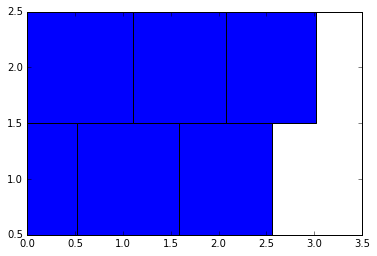

In [8]:
#todo: compute speedup, plot it over varying # of threads/procs

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for info in g:
    ax.broken_barh([(info['start_time'], info['elapsed_time'])], (info['wid']+.5,1))

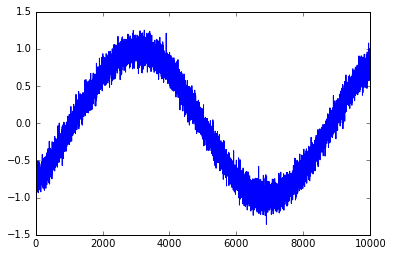

In [69]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

a = np.linspace(-.9,2.3*np.pi,num=10000)
a = np.sin(a) + np.random.randn(len(a))*.1

plt.plot(a)

CPU times: user 2min 16s, sys: 138 ms, total: 2min 16s
Wall time: 2min 16s


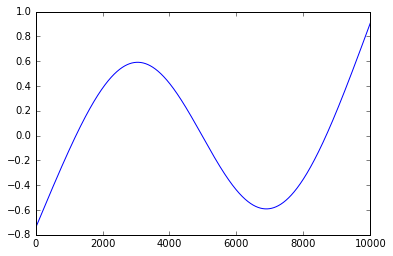

In [92]:
%%time
smooth(a,N=1000000)
plt.plot(a)

In [73]:
%timeit test2(14**4)

1 loops, best of 3: 2.47 s per loop


In [74]:
%timeit test(14**4)

1 loops, best of 3: 2.43 s per loop


In [90]:
%%time
ex = futures.ThreadPoolExecutor(4)
#ex = futures.ProcessPoolExecutor()
#ex = None

g = [11**4]*10

if ex is None:
    pmap = map
else:
    pmap = ex.map


for a in pmap(test3, g):
    print('.', end='')

if ex is not None:
    ex.shutdown()

..........CPU times: user 6.58 s, sys: 10.7 ms, total: 6.59 s
Wall time: 1.94 s


In [38]:
%timeit test(12**4)

1 loops, best of 3: 723 ms per loop
